<a href="https://colab.research.google.com/github/adilakshmivadavalli/Experience/blob/master/FL_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
Data = pd.read_csv(r"/content/sample_data/data_banknote_authentication.csv")
Data = Data.to_numpy()

In [3]:
m, n = Data.shape
n0 = n - 1

In [4]:
randseq = np.random.permutation(m)
Data = Data[randseq[0:m], 0:n]

In [5]:
trainval = math.floor(m*0.8)
testval = m - trainval

In [6]:
NumofClients = 10

vec = np.random.randint(5, trainval, NumofClients)
total = np.sum(vec)
list_clients = (np.ceil((vec/total)*trainval)).astype(int)
rem = trainval - np.sum(list_clients)
list_clients[-1] = list_clients[-1] + rem

In [9]:
for i in range(NumofClients):
    if i == 0:
        SplitData = Data[0:list_clients[0], :]
    else:
        SplitData = Data[np.sum(list_clients[0:i]):np.sum(list_clients[0:i])+list_clients[i], :]
    pd.DataFrame(SplitData).to_csv("/content/sample_data/data_split/data_split_"+str(i+1)+ ".csv", header=False, index=False)

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
X_test = Data[trainval:m+1, 0:n0].T
y_test = Data[trainval:m+1, n0].reshape(1, m-trainval)

In [12]:
def sigmoid(z):
    s = 1/(1+np.exp(-z))
    return s

In [13]:
L = 4
nx = np.array([n0, 5, 5, 1])

In [15]:
# Server initializes the global model

W1 = np.random.randn(nx[1],nx[0])
b1 = np.random.randn(nx[1],1)

W2 = np.random.randn(nx[2],nx[1])
b2 = np.random.randn(nx[2],1)

W3 = np.random.randn(nx[3],nx[2])
b3 = np.random.randn(nx[3],1)

# Saving the global model in csv files

pd.DataFrame(W1).to_csv("/content/sample_data/avg_paramters/W1_avg.csv", header=False, index=False)
pd.DataFrame(W2).to_csv("/content/sample_data/avg_paramters/W2_avg.csv", header=False, index=False)
pd.DataFrame(W3).to_csv("/content/sample_data/avg_paramters/W3_avg.csv", header=False, index=False)

pd.DataFrame(b1).to_csv("/content/sample_data/avg_paramters/b1_avg.csv", header=False, index=False)
pd.DataFrame(b2).to_csv("/content/sample_data/avg_paramters/b2_avg.csv", header=False, index=False)
pd.DataFrame(b3).to_csv("/content/sample_data/avg_paramters/b3_avg.csv", header=False, index=False)

In [19]:
learning_rate = 0.05
iterations = 10
rounds = 100

Avg_Loss = np.zeros((rounds,1))
Accuracy = np.zeros((rounds,1))

for r in range(rounds):

    for client in range(NumofClients):


        Data_X = pd.read_csv("/content/sample_data/data_split/data_split_"+str(client+1)+".csv", header=None)
        Data_X = Data_X.to_numpy()

        m_X, n_X = Data_X.shape
        n0 = n_X - 1

        X_train = Data_X[:, 0:n0].T
        y_train = Data_X[:, n0].reshape(1, m_X)

        # Each client uses the global model received from
        # the server in the first iteration
        W1 = pd.read_csv("/content/sample_data/avg_paramters/W1_avg.csv", header=None)
        W1 = W1.to_numpy()

        W2 = pd.read_csv("/content/sample_data/avg_paramters/W2_avg.csv", header=None)
        W2 = W2.to_numpy()

        W3 = pd.read_csv("/content/sample_data/avg_paramters/W3_avg.csv", header=None)
        W3 = W3.to_numpy()

        b1 = pd.read_csv("/content/sample_data/avg_paramters/b1_avg.csv", header=None)
        b1 = b1.to_numpy()

        b2 = pd.read_csv("/content/sample_data/avg_paramters/b2_avg.csv", header=None)
        b2 = b2.to_numpy()

        b3 = pd.read_csv("/content/sample_data/avg_paramters/b3_avg.csv", header=None)
        b3 = b3.to_numpy()

        J = np.zeros((iterations,1))

        for i in range(iterations):

            # Forward propagation
            Z1 = np.dot(W1, X_train) + b1
            A1 = sigmoid(Z1)

            Z2 = np.dot(W2, A1) + b2
            A2 = sigmoid(Z2)

            Z3 = np.dot(W3, A2) + b3
            A3 = sigmoid(Z3)

            # J[i] = (-1/m_X)*np.sum(y_train*np.log(A3) + (1-y_train)*np.log(1-A3))

            # Backward propagation
            dZ3 = A3-y_train
            dW3 = (1/m_X)*np.dot(dZ3, A2.T)
            db3 = (1/m_X)*np.sum(dZ3, axis = 1, keepdims = True)

            dA2 = A2*(1-A2)
            dZ2 = np.dot(W3.T, dZ3)*dA2
            dW2 = (1/m_X)*np.dot(dZ2, A1.T)
            db2 = (1/m_X)*np.sum(dZ2, axis = 1, keepdims = True)

            dA1 = A1*(1-A1)
            dZ1 = np.dot(W2.T, dZ2)*dA1
            dW1 = (1/m_X)*np.dot(dZ1, X_train.T)
            db1 = (1/m_X)*np.sum(dZ1, axis = 1, keepdims = True)

            W1 = W1 - learning_rate*dW1
            b1 = b1 - learning_rate*db1

            W2 = W2 - learning_rate*dW2
            b2 = b2 - learning_rate*db2

            W3 = W3 - learning_rate*dW3
            b3 = b3 - learning_rate*db3

        # Each client sends the local models to
        # the server
        pd.DataFrame(W1*m_X).to_csv("/content/sample_data/ind_parameters/W1_"+str(client+1)+".csv", header=False, index=False)
        pd.DataFrame(W2*m_X).to_csv("/content/sample_data/ind_parameters/W2_"+str(client+1)+".csv", header=False, index=False)
        pd.DataFrame(W3*m_X).to_csv("/content/sample_data/ind_parameters/W3_"+str(client+1)+".csv", header=False, index=False)

        pd.DataFrame(b1*m_X).to_csv("/content/sample_data/ind_parameters/b1_"+str(client+1)+".csv", header=False, index=False)
        pd.DataFrame(b2*m_X).to_csv("/content/sample_data/ind_parameters/b2_"+str(client+1)+".csv", header=False, index=False)
        pd.DataFrame(b3*m_X).to_csv("/content/sample_data/ind_parameters/b3_"+str(client+1)+".csv", header=False, index=False)

    # The server aggregate/average the local models

    W1 = np.zeros([nx[1],nx[0]])
    b1 = np.zeros([nx[1],1])

    W2 = np.zeros([nx[2],nx[1]])
    b2 = np.zeros([nx[2],1])

    W3 = np.zeros([nx[3],nx[2]])
    b3 = np.zeros([nx[3],1])

    for client in range(NumofClients):
        W1 = W1 + pd.read_csv("/content/sample_data/ind_parameters/W1_"+str(client+1)+".csv", header=None)
        W2 = W2 + pd.read_csv("/content/sample_data/ind_parameters/W2_"+str(client+1)+".csv", header=None)
        W3 = W3 + pd.read_csv("/content/sample_data/ind_parameters/W3_"+str(client+1)+".csv", header=None)

        b1 = b1 + pd.read_csv("/content/sample_data/ind_parameters/b1_"+str(client+1)+".csv", header=None)
        b2 = b2 + pd.read_csv("/content/sample_data/ind_parameters/b2_"+str(client+1)+".csv", header=None)
        b3 = b3 + pd.read_csv("/content/sample_data/ind_parameters/b3_"+str(client+1)+".csv", header=None)

    W1 = W1.to_numpy()
    W2 = W2.to_numpy()
    W3 = W3.to_numpy()

    b1 = b1.to_numpy()
    b2 = b2.to_numpy()
    b3 = b3.to_numpy()

    W1_avg = W1/trainval
    W2_avg = W2/trainval
    W3_avg = W3/trainval

    b1_avg = b1/trainval
    b2_avg = b2/trainval
    b3_avg = b3/trainval

    pd.DataFrame(W1_avg).to_csv("/content/sample_data/avg_paramters/W1_avg.csv", header=False, index=False)
    pd.DataFrame(W2_avg).to_csv("/content/sample_data/avg_paramters/W2_avg.csv", header=False, index=False)
    pd.DataFrame(W3_avg).to_csv("/content/sample_data/avg_paramters/W3_avg.csv", header=False, index=False)

    pd.DataFrame(b1_avg).to_csv("/content/sample_data/avg_paramters/b1_avg.csv", header=False, index=False)
    pd.DataFrame(b2_avg).to_csv("/content/sample_data/avg_paramters/b2_avg.csv", header=False, index=False)
    pd.DataFrame(b3_avg).to_csv("/content/sample_data/avg_paramters/b3_avg.csv", header=False, index=False)

    # Evaluation of the global model on
    # the testing dataset
    Z1 = np.dot(W1_avg, X_test) + b1_avg
    A1 = sigmoid(Z1)

    Z2 = np.dot(W2_avg, A1) + b2_avg
    A2 = sigmoid(Z2)

    Z3 = np.dot(W3_avg, A2) + b3_avg
    A3 = sigmoid(Z3)

    Avg_Loss[r] = (-1/m)*np.sum(y_test*np.log(A3) + (1-y_test)*np.log(1-A3))

    y_pred = A3 > 0.5
    Accuracy[r] = 1 - np.sum(abs(y_pred - y_test))/testval

    print(f"Round: {r+1}, Loss: {Avg_Loss[r]}, Accuracy: {Accuracy[r]}")


Round: 1, Loss: [0.16077286], Accuracy: [0.36363636]
Round: 2, Loss: [0.15672733], Accuracy: [0.38545455]
Round: 3, Loss: [0.15271974], Accuracy: [0.43272727]
Round: 4, Loss: [0.14863349], Accuracy: [0.51636364]
Round: 5, Loss: [0.14443287], Accuracy: [0.55636364]
Round: 6, Loss: [0.14017159], Accuracy: [0.57454545]
Round: 7, Loss: [0.13595251], Accuracy: [0.59272727]
Round: 8, Loss: [0.13186282], Accuracy: [0.64727273]
Round: 9, Loss: [0.12794979], Accuracy: [0.65818182]
Round: 10, Loss: [0.12422963], Accuracy: [0.67272727]
Round: 11, Loss: [0.12069811], Accuracy: [0.67636364]
Round: 12, Loss: [0.11733829], Accuracy: [0.69090909]
Round: 13, Loss: [0.11412749], Accuracy: [0.69818182]
Round: 14, Loss: [0.11104262], Accuracy: [0.70545455]
Round: 15, Loss: [0.1080631], Accuracy: [0.71272727]
Round: 16, Loss: [0.10517178], Accuracy: [0.72363636]
Round: 17, Loss: [0.10235455], Accuracy: [0.72363636]
Round: 18, Loss: [0.09959928], Accuracy: [0.73090909]
Round: 19, Loss: [0.09689496], Accurac

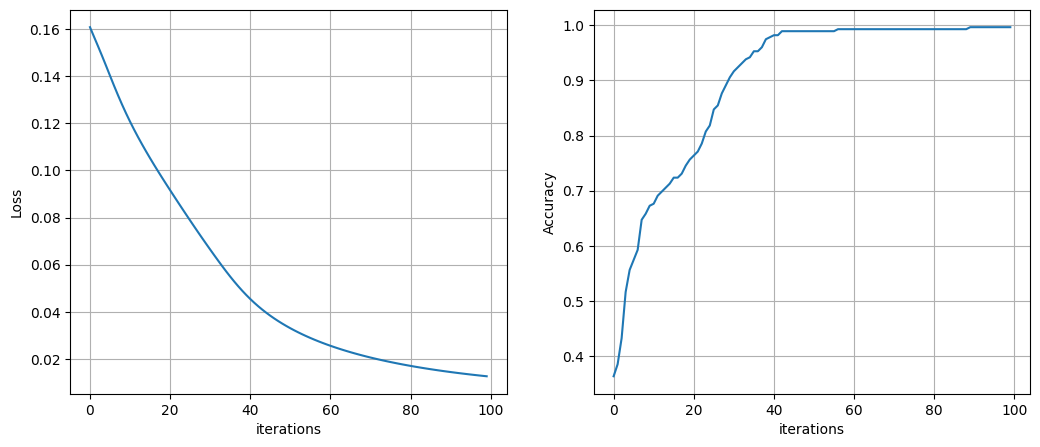

In [20]:
plt.subplot(1, 2, 1)
plt.plot(Avg_Loss)
plt.grid()
plt.xlabel('iterations')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(Accuracy)
plt.grid()
plt.xlabel('iterations')
plt.ylabel('Accuracy')

plt.subplots_adjust(left=0,
                    bottom=0.1,
                    right=1.5,
                    top=0.9,
                    wspace=0.2,
                    hspace=0.2)

plt.show()